In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
# from mrsc.src.importData import *
import mrsc.src.utils as utils

from mrsc.src.from_tslib.svdWrapper import SVDWrapper as SVD
from mrsc.src.from_tslib.tsSVDModel import SVDModel
from mrsc.src.from_tslib import tsUtils

plt.rcParams.update({'font.size': 14})

In [197]:
def hsvt(df, rank): 
    """
    Input:
        df: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(df, full_matrices=False)
    s[rank:].fill(0)
    vals = (np.dot(u*s, v))
    return pd.DataFrame(vals, index = df.index, columns = df.columns)

def svd_spectrum(df, n):
    # svd spectrum for the first n singvals
    u, s, vh = np.linalg.svd(df)
    
    plt.title("Singular Value Spectrum - the largest {} values".format(n))
    plt.plot(s[:n])
    plt.show()
    print(s)
    for k in range(1,n+1):
        print(k,"th singular value: ", np.sum(s[:k])/np.sum(s))

In [192]:
pd.read_csv("../data/labelsFall2014.csv").columns

Index(['Unnamed: 0', 'user_id', 'timestamp', 'Alertness_Morning',
       'Happiness_Morning', 'Energy_Morning', 'Health_Morning',
       'Calmness_Morning', 'Alertness_Evening', 'Happiness_Evening',
       'Energy_Evening', 'Health_Evening', 'Calmness_Evening'],
      dtype='object')

In [193]:
pd.read_csv("../data/surveyFeatsFall2014.csv").columns

Index(['Unnamed: 0', 'user_id', 'timestamp', 'no_sleep_24', 'sleep_latency',
       'pre_sleep_activity', 'wake_reason', 'awakening', 'count_awakening',
       'nap', 'count_nap', 'first_event_none', 'Presleep_media_interation',
       'Presleep_personal_interaction', 'awakening_occations',
       'awakening_duration', 'nap_occations', 'nap_duration', 'Time_in_bed',
       'academic', 'count_academic', 'study_duration', 'exercise',
       'extracurricular', 'count_extracurricular', 'overslept',
       'caffeine_count', 'drugs', 'drugs_alcohol', 'drugs_alert',
       'drugs_sleepy', 'drugs_tired', 'academic_duration',
       'exercise_occations', 'exercise_duration', 'extracurricular_duration',
       'negative_interaction', 'positive_interaction',
       'sleep_try_time_mins_since_midnight', 'wake_time_mins_since_midnight',
       'caffeine_time_mins_since_midnight', 'first_event_mins_since_midnight'],
      dtype='object')

(106, 30)


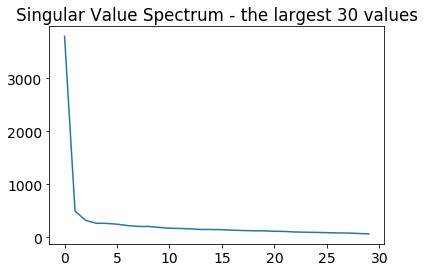

[3797.57082195  495.64742695  320.70848472  265.0127341   262.1442388
  247.4397095   221.38818284  205.43491175  204.71303114  186.9352385
  171.24350295  166.90153081  159.05298013  148.14841793  147.28230232
  143.44349492  134.72712568  127.68820631  123.44808823  121.22055728
  113.29005547  110.39962025   99.8852395    95.83249848   91.73757221
   87.44549012   82.32912649   80.02350239   72.48339594   63.68379815]
1 th singular value:  0.4443026479440843
2 th singular value:  0.5022916821358082
3 th singular value:  0.5398134653120475
4 th singular value:  0.5708190383535692
5 th singular value:  0.6014890073688133
6 th singular value:  0.6304385973280655
7 th singular value:  0.6563402487970933
8 th singular value:  0.6803754227415265
9 th singular value:  0.7043261391512327
10 th singular value:  0.7261969153273137
11 th singular value:  0.7462318127319242
12 th singular value:  0.7657587144172079
13 th singular value:  0.7843673628269091
14 th singular value:  0.8017002151840

In [333]:
metric = 'Health_Evening'

data_table = pd.DataFrame()
for year in [2013, 2014, 2015]:

    filename_1 = "../data/surveyFeatsFall{}.csv".format(year)
    data_1 = pd.read_csv(filename_1)

    filename_2 = "../data/labelsFall{}.csv".format(year)
    data_2 = pd.read_csv(filename_2)

    d = data_1.merge(data_2, left_on=['user_id', 'timestamp'], right_on=['user_id', 'timestamp'])

    table = pd.pivot_table(d, values=metric, index="user_id", columns="timestamp")
    table = table.T.reset_index(drop=True).T
    table = table.iloc[:,:30]
    
    data_table = pd.concat([data_table,table], axis=0)

print(data_table.shape)
example_table = data_table.T.fillna(data_table.mean(axis=1), axis=0).T
svd_spectrum(example_table, 30)
target_ids = list(example_table.index)

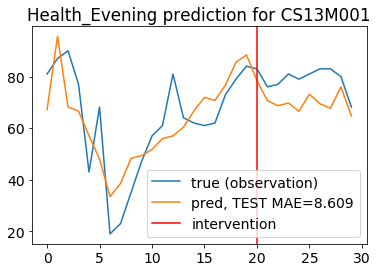

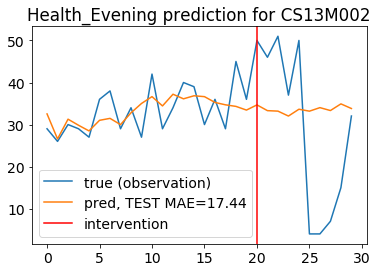

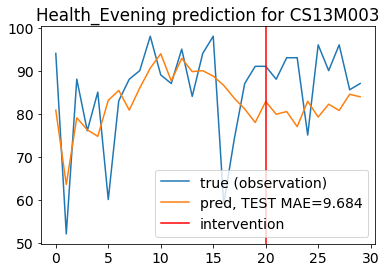

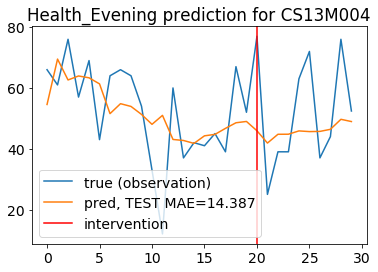

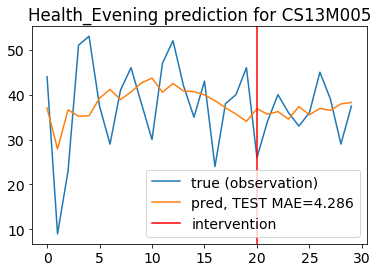

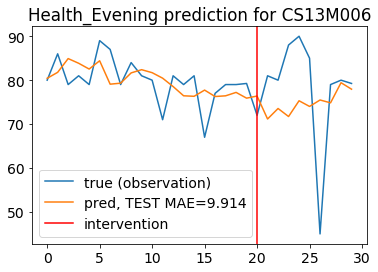

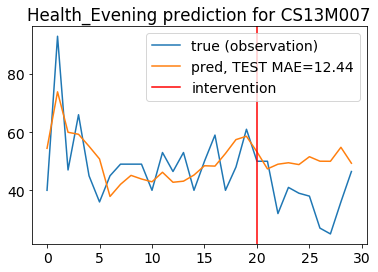

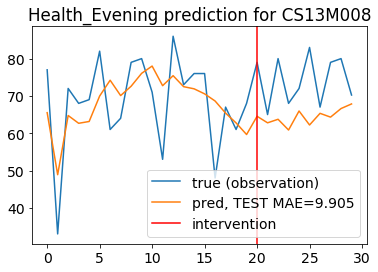

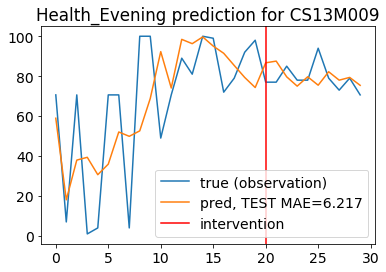

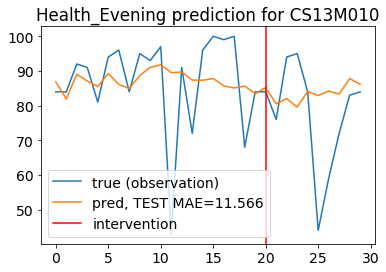

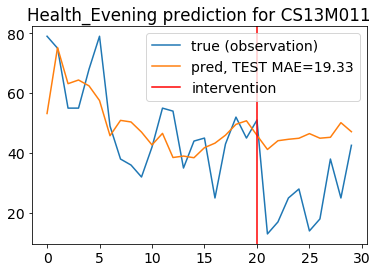

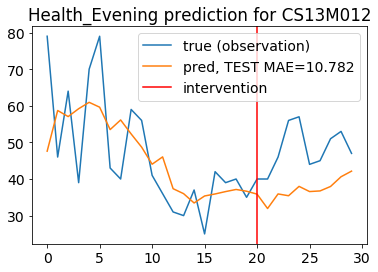

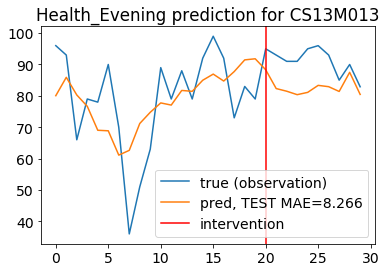

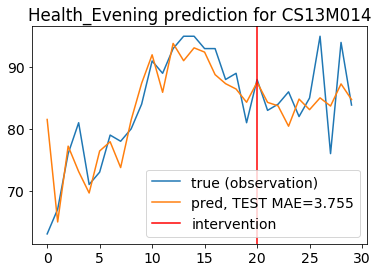

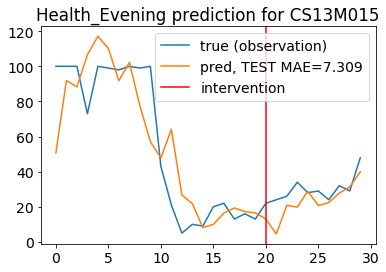

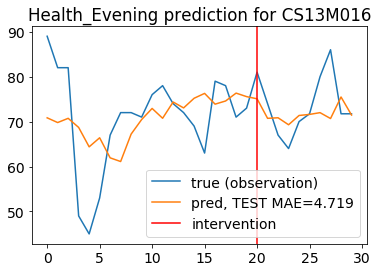

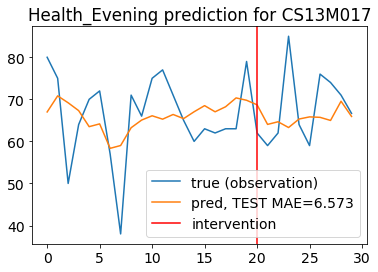

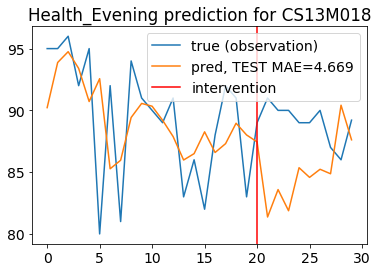

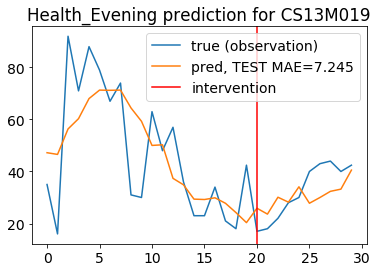

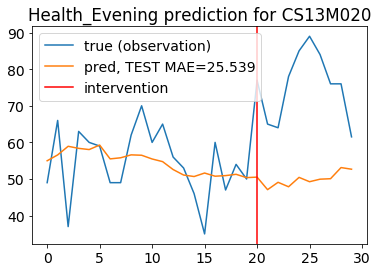

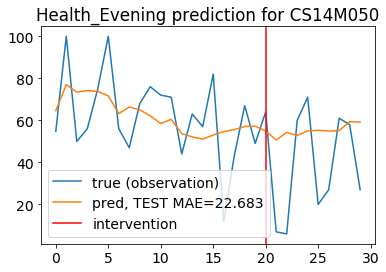

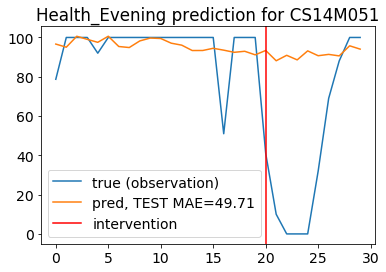

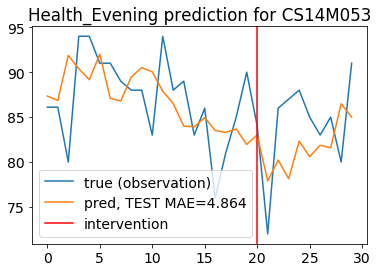

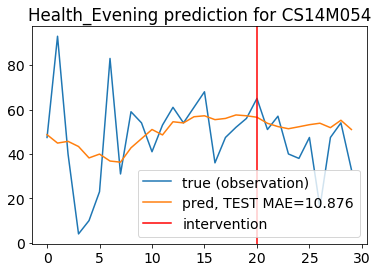

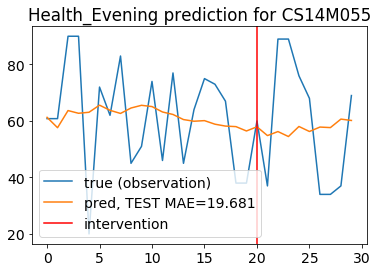

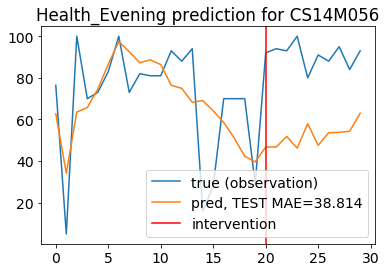

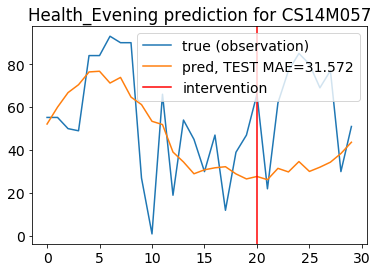

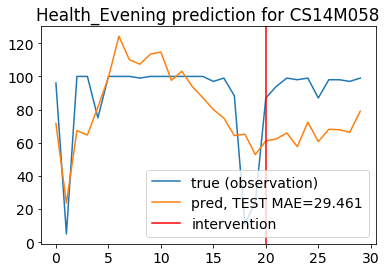

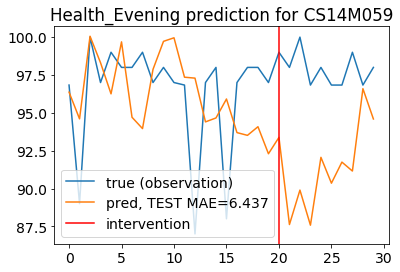

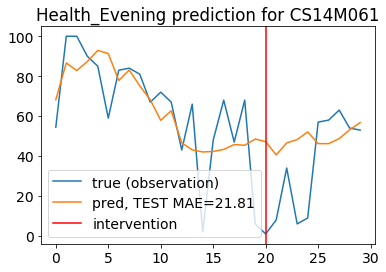

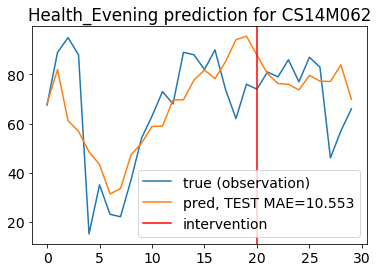

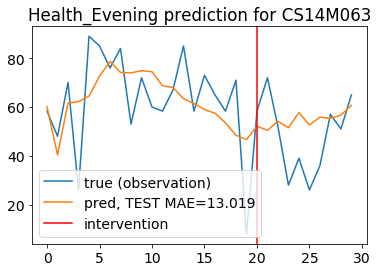

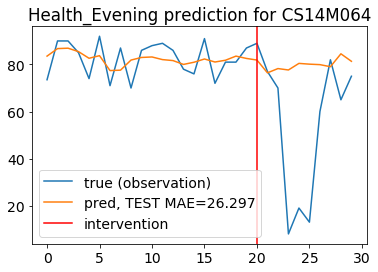

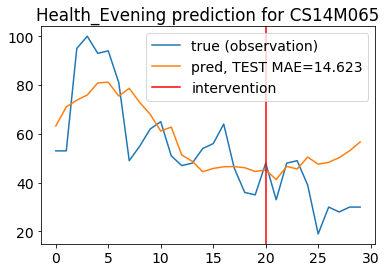

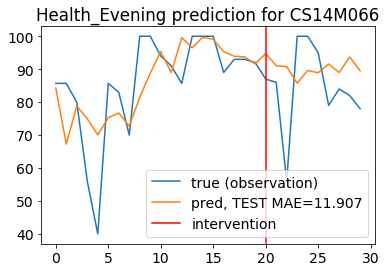

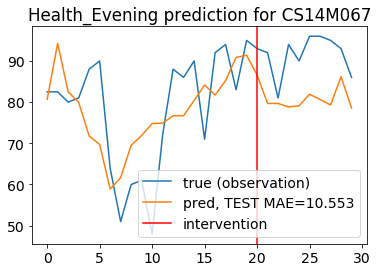

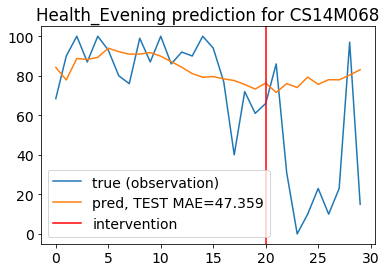

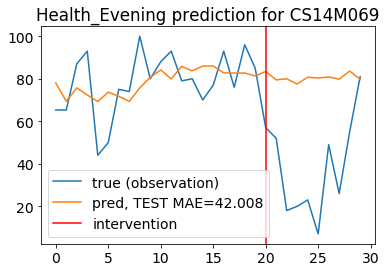

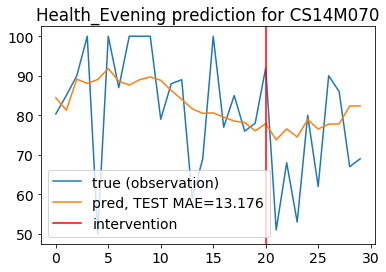

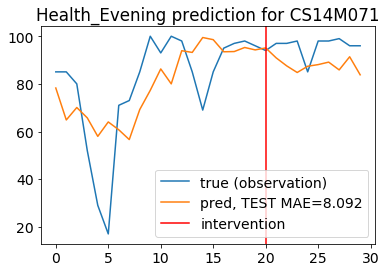

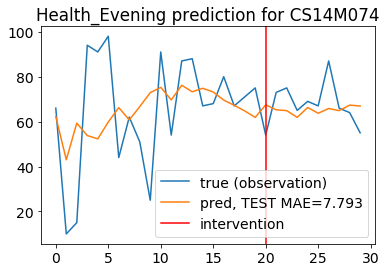

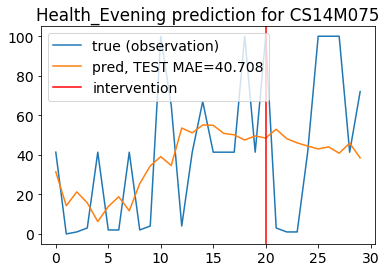

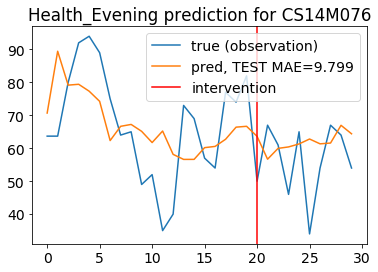

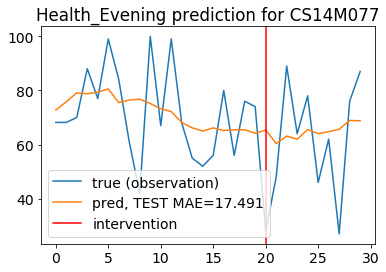

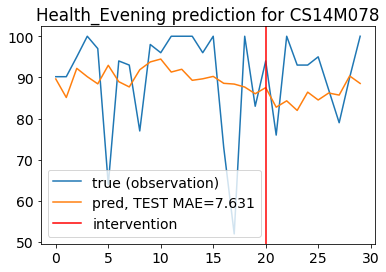

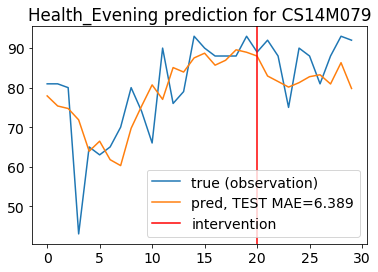

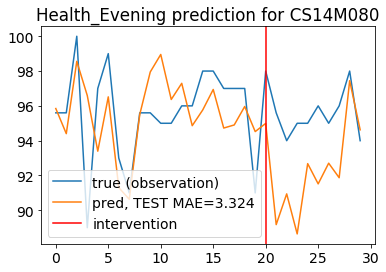

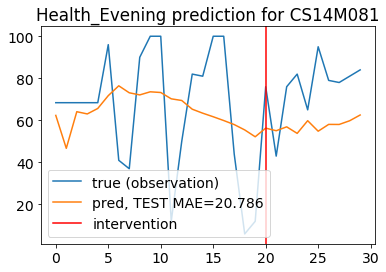

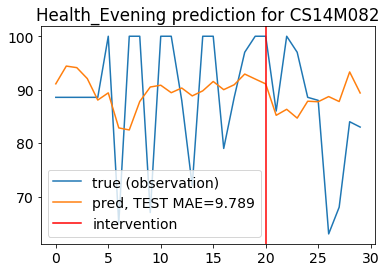

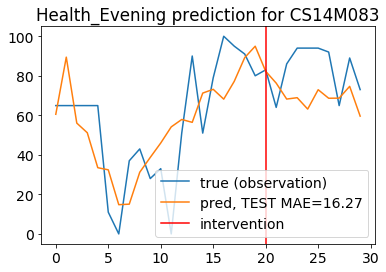

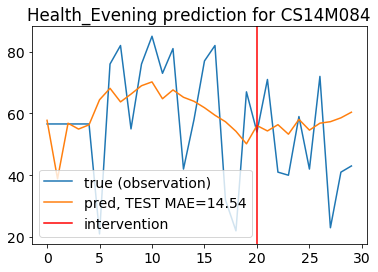

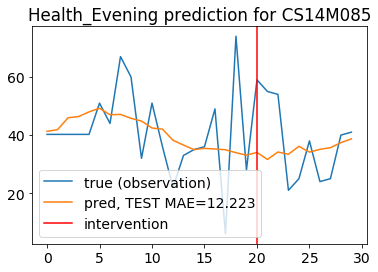

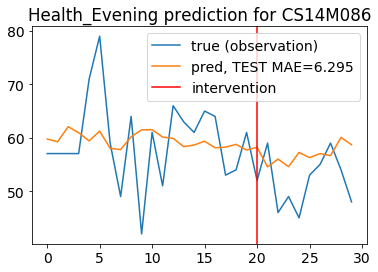

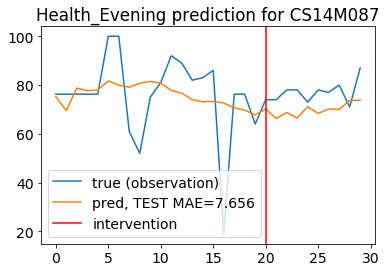

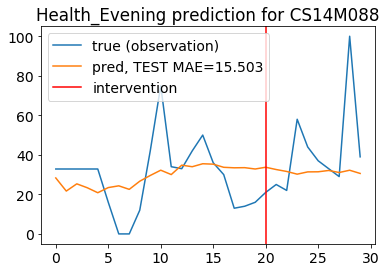

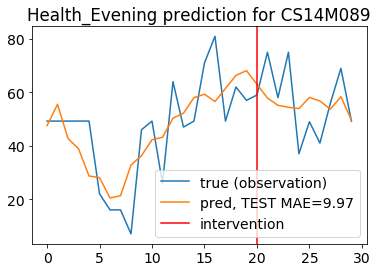

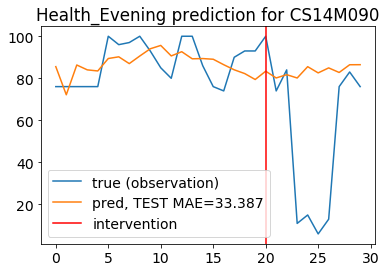

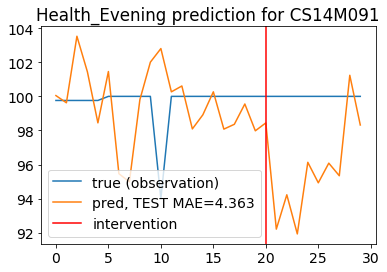

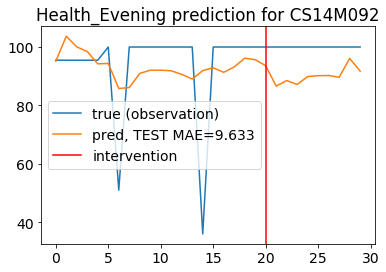

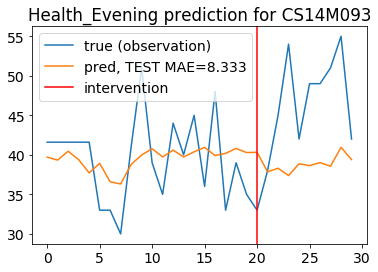

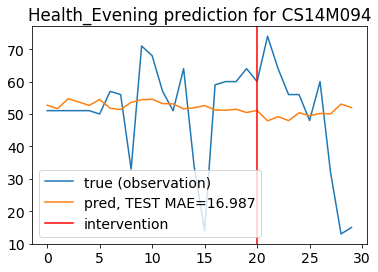

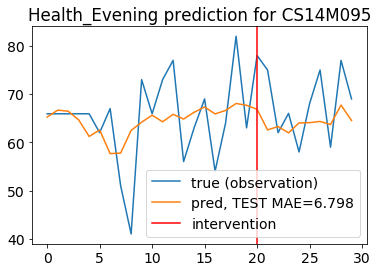

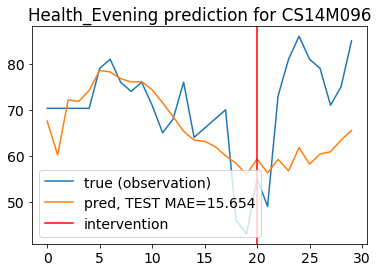

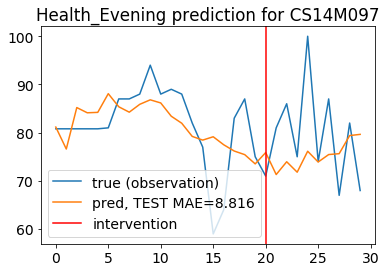

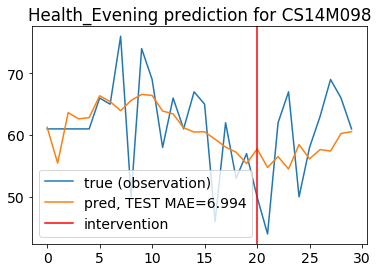

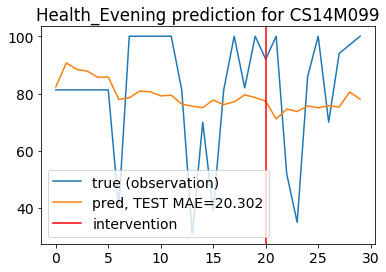

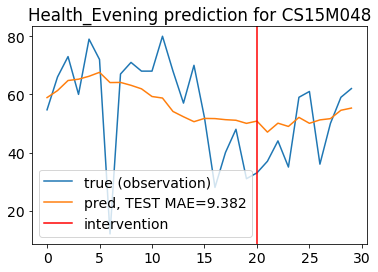

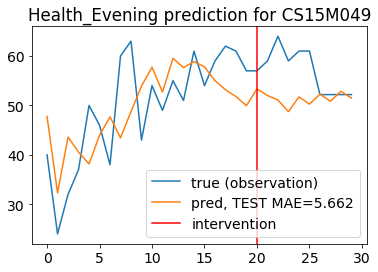

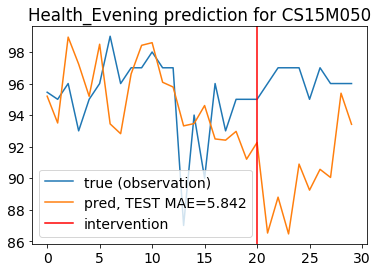

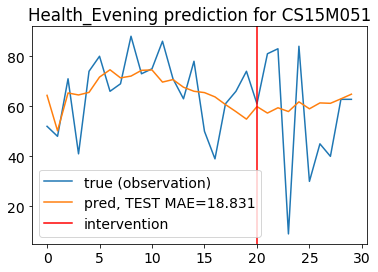

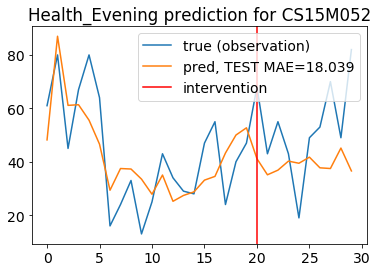

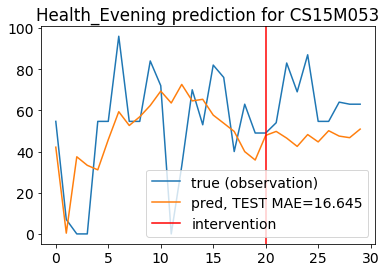

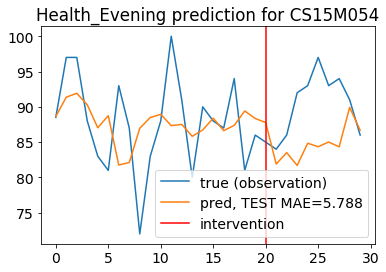

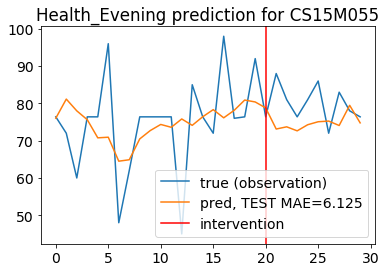

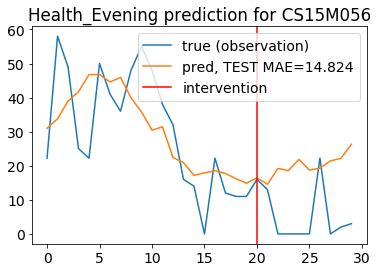

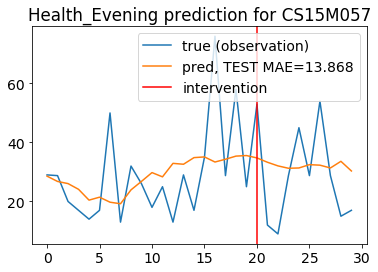

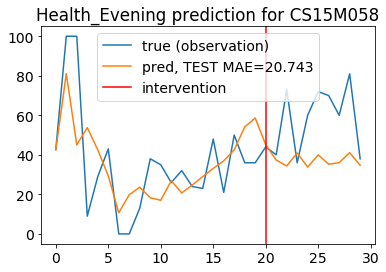

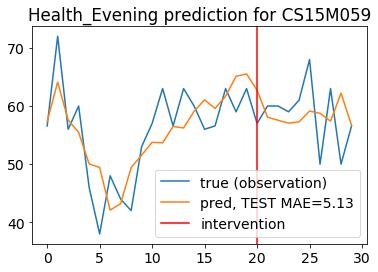

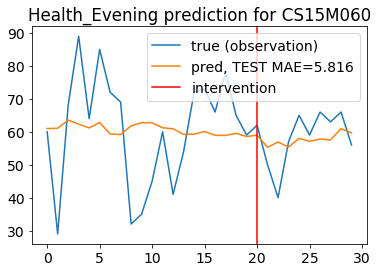

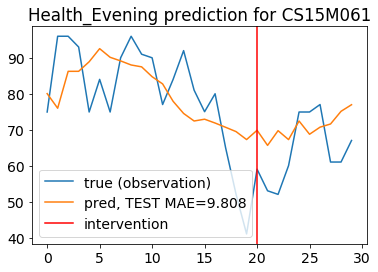

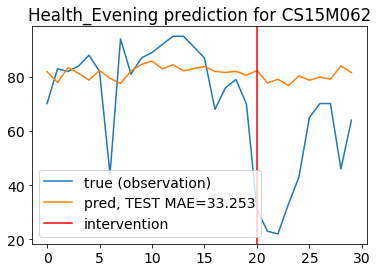

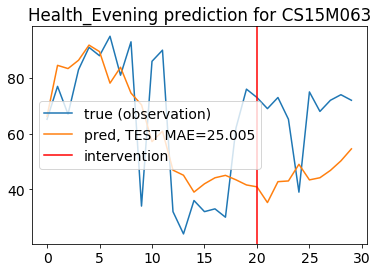

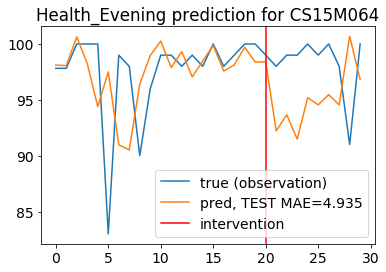

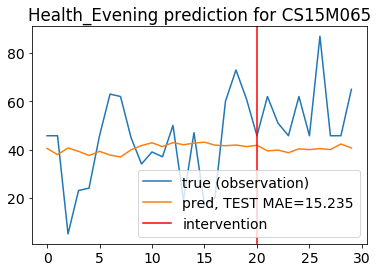

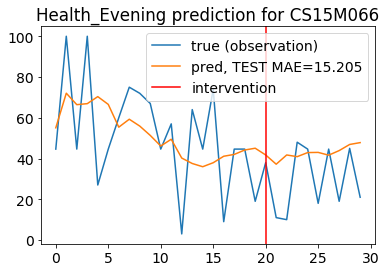

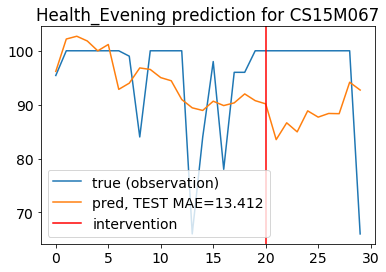

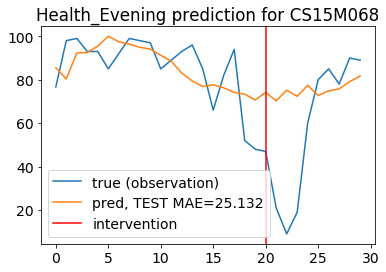

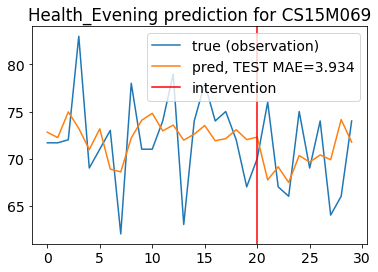

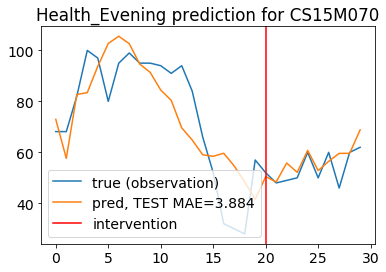

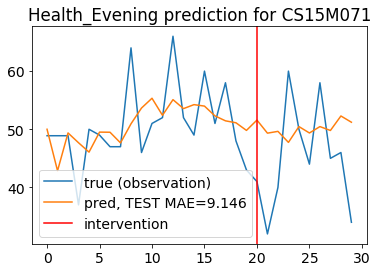

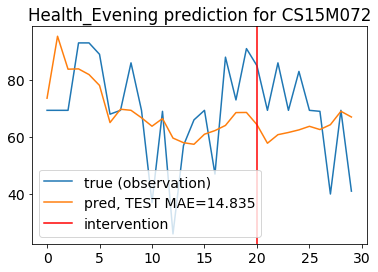

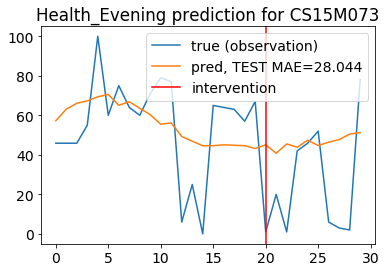

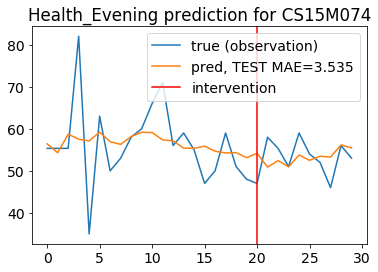

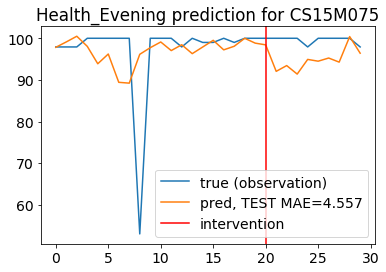

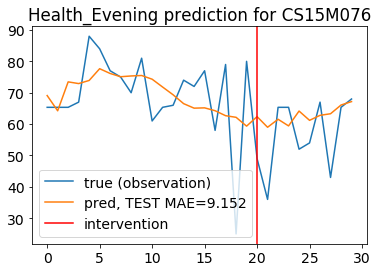

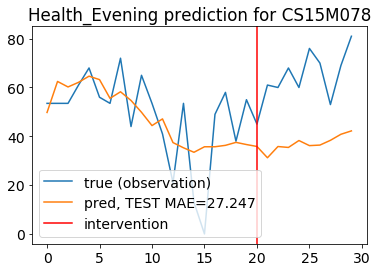

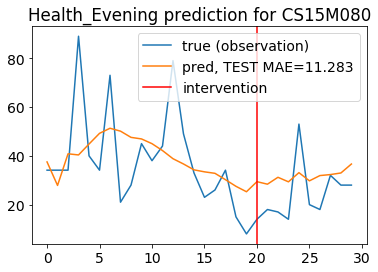

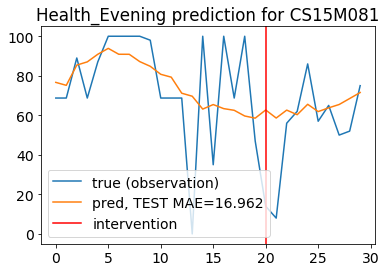

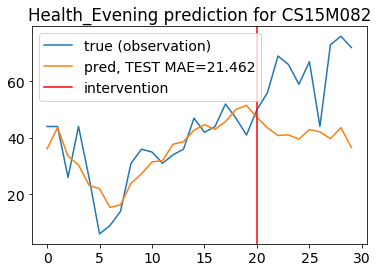

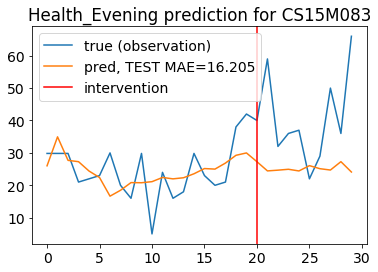

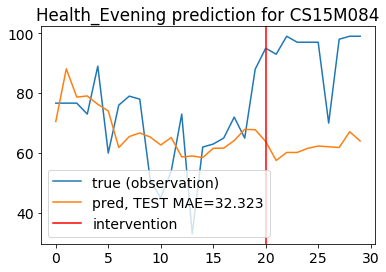

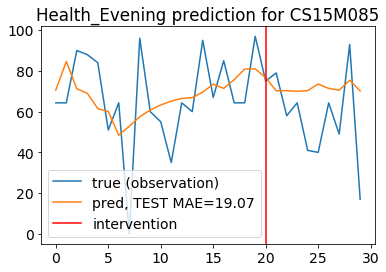

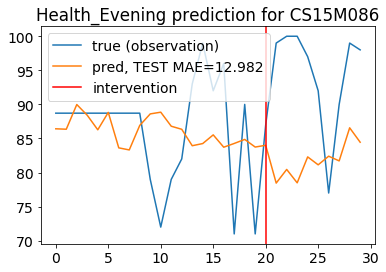

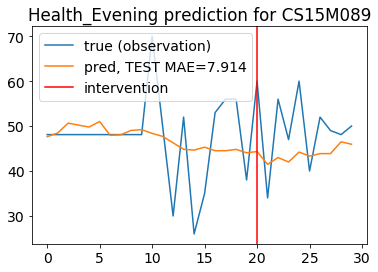

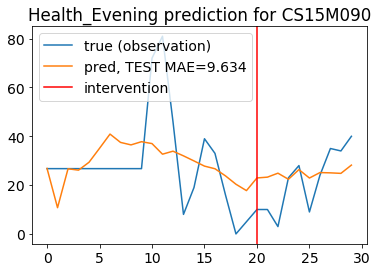

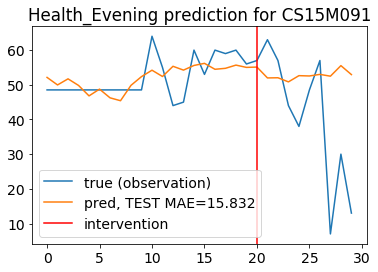

In [331]:
intervention = 20
numSingvals = 3

#####
mae_list = []
for target_id in target_ids:
    example_table_pre = example_table.iloc[:,:intervention]
    example_table_post = example_table.iloc[:,intervention:]
    donor = example_table.loc[example_table.index != target_id]

    example_table_pre_hsvt = utils.hsvt(example_table_pre, numSingvals)
    target_train = example_table_pre_hsvt.loc[target_id]
    donor_train = example_table_pre_hsvt.loc[example_table.index != target_id]

    target_test = example_table_post.loc[target_id]
    donor_test = example_table_post.loc[example_table.index != target_id]

    beta = np.dot(target_train.T, np.linalg.pinv(donor_train))
    pred = np.dot(donor.T, beta)
    mae = np.mean(np.abs(pred[intervention:] - target_test))
    mae_list.append(mae)

#     beta2 = np.linalg.lstsq(donor_train.T,target_train)[0]
#     pred2 = np.dot(donor.T, beta2)
#     mae2 = np.mean(np.abs(pred2[intervention:] - target_test))

    plt.title("{} prediction for {}".format(metric, target_id))
    plt.plot(example_table.loc[target_id].values, label="true (observation)")
    plt.plot(pred, label = "pred, TEST MAE={}".format(mae.round(3)))
#     plt.plot(pred2, label = "pred2, TEST MAE={}".format(mae2.round(3)))
    plt.axvline(intervention, color="red", label= "intervention")
    plt.legend()
    plt.show()

In [332]:
np.mean(mae_list)

14.436236876552565

# Intervention = 1{condition}

In [282]:
actigraphy = pd.read_csv("../data/All_Actigraphy.csv")
unique_ids = actigraphy.ID.unique()
actigraphy["ts_index"] = actigraphy.groupby(['ID']).cumcount()+1

In [335]:
metric = "Actigraphy - Duration"
df = pd.pivot_table(actigraphy, values=metric, index="ID", columns="ts_index")
df = df.iloc[:,:30]

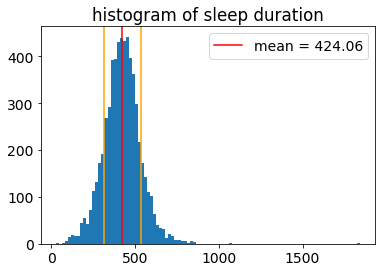

In [323]:
vals = df.values.flatten()
mean = np.nanmean(vals)
std = np.nanstd(vals)
plt.title("histogram of sleep duration")
plt.hist(vals, bins=100)
plt.axvline(mean, color='red', label = "mean = {}".format(mean.round(2)))
plt.axvline(mean+std, color='orange')
plt.axvline(mean-std, color='orange')

plt.legend()
plt.show()

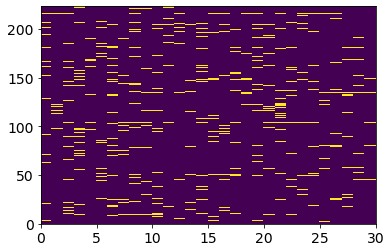

In [321]:
threshold = mean - 1.5*std

df_new = (df < threshold)
plt.pcolor(df_new)
plt.show()